In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy import signal
from scipy.stats import norm
from scipy.optimize import curve_fit
import os


import statsmodels.api as sm
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.vector_ar.vecm import coint_johansen


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


import sklearn
from sklearn.neighbors import KernelDensity



## Data preparation for analysis and validation of SF
* SF1 Endogenous and self-sustained growth of output, with persistent fluctuations.
* SF4 Aggregate consumption is less volatile than GDP, and aggregate investments are
more volatile than GDP.
* SF6 Synchronization of the business cycle and emission dynamics.

(Partial) replication of Dosi (2010) fig 1 and 2, Lamperti et al (2018) fig 2 and 8

In [7]:
#SF 1,4,6
#df_1 = pd.read_csv('1234_model.csv')
#print current path
print(os.getcwd())
df_1 = pd.read_csv('../data/1234_model.csv')
T = range(len(df_1.GDP))

def indexnumber(ts):
    return 100 * ts / ts[0]

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Set parameters for bandpass filters
bk_low = 18
bk_high = 96
bk_K = 36

real_GDP_1 = df_1.GDP.iloc[300:].to_numpy() / df_1.p_ep.iloc[300:].to_numpy()
real_C = df_1.total_C.iloc[300:].to_numpy() / df_1.p_ep.iloc[300:].to_numpy()
real_I = df_1.total_I.iloc[300:].to_numpy() / df_1.p_ep.iloc[300:].to_numpy()
#smoothen real_I 
real_I = signal.savgol_filter(real_I, 12, 2)

x = np.arange(0, 361, 60)
years = np.arange(2020, 2051, 5)

gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP_1), bk_low, bk_high, bk_K)
C_filtered = sm.tsa.filters.bkfilter(np.log(real_C), bk_low, bk_high, bk_K)
I_filtered = sm.tsa.filters.bkfilter(np.log(real_I), bk_low, bk_high, bk_K)

Em_filtered = sm.tsa.filters.bkfilter(np.log(df_1.em_index.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)
EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df_1.D_ep.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)


T_filter = range(len(gdp_filtered))

/Users/mengeshi/Documents/GitHub/Capsule_Climate/results


/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_19344/3268714683.py:32: RuntimeWarning: divide by zero encountered in log
  Em_filtered = sm.tsa.filters.bkfilter(np.log(df_1.em_index.iloc[300:].to_numpy()), bk_low, bk_high, bk_K)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/signal/_signaltools.py:508: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_19344/90053511.py:39: RuntimeWarning: divide by zero encountered in log
  ax3.plot(np.log(df_1.em_index.iloc[300:].to_numpy()), label='Em', color=viridis_cmap(0.99))


<Figure size 432x288 with 0 Axes>

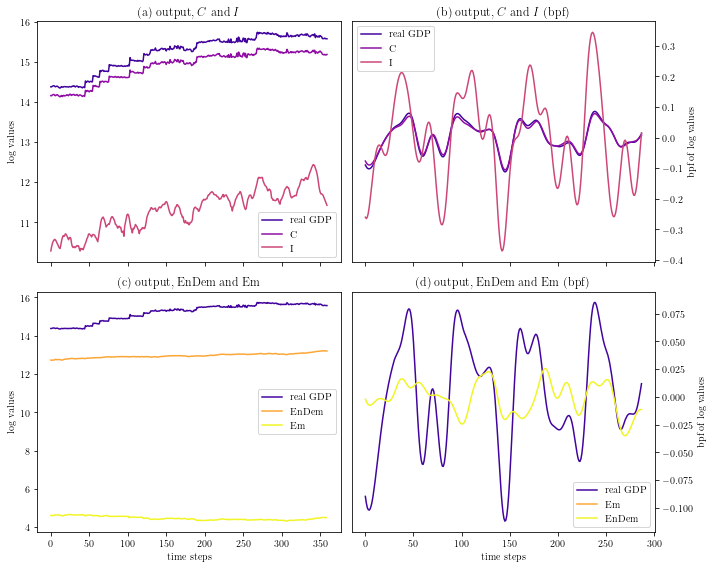

In [10]:
#SF 1,4,6
from matplotlib.cm import get_cmap

#plt.style.use(['science','ieee'])





plt.tight_layout()

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,8))
viridis_cmap = get_cmap('plasma')


ax1.plot(np.log(real_GDP_1), label='real GDP', color=viridis_cmap(0.1))
ax1.plot(np.log(real_C), label='C', color=viridis_cmap(0.3))
ax1.plot(np.log(real_I), label='I', color=viridis_cmap(0.5))
#remove x axis labels
ax1.set_xticklabels([])
ax1.set_ylabel('log values')
ax1.set_title('(a) output, $C$ and $I$')
ax1.legend()

ax2.plot(gdp_filtered, label='real GDP', color=viridis_cmap(0.1))
ax2.plot(C_filtered, label='C', color=viridis_cmap(0.3))
ax2.plot(I_filtered, label='I', color=viridis_cmap(0.5))
#put axis labels to the right
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
#axis labels to the right as well 
ax2.set_xticklabels([])
ax2.set_ylabel('bpf of log values')
ax2.set_title('(b) output, $C$ and $I$ (bpf)')
ax2.legend()

ax3.plot(np.log(real_GDP_1), label='real GDP', color=viridis_cmap(0.1))
ax3.plot(np.log(df_1.D_ep.iloc[300:].to_numpy()), label='EnDem', color=viridis_cmap(0.8))
ax3.plot(np.log(df_1.em_index.iloc[300:].to_numpy()), label='Em', color=viridis_cmap(0.99))
ax3.set_xlabel('time steps')
ax3.set_ylabel('log values')
ax3.set_title('(c) output, EnDem and Em')
ax3.legend()

ax4.plot(gdp_filtered, label='real GDP', color=viridis_cmap(0.1))
ax4.plot(Em_filtered, label='Em', color=viridis_cmap(0.8))
ax4.plot(EnDem_filtered, label='EnDem', color=viridis_cmap(0.99))
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position('right')
ax4.set_xlabel('time steps')
ax4.set_ylabel('bpf of log values')
ax4.set_title('(d) output, EnDem and Em (bpf)')
ax4.legend()

plt.tight_layout()
#plt.savefig('../validation/timeseries_gdp.pdf', bbox_inches='tight')
plt.show()



## Data Preperation and SF 12, 5
* SF12  labor income share is anti-cyclical
* SF5  cross correlations of a large number of outputs and real GDP 

In [12]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as smt
import matplotlib.pyplot as plt


def compute_avg_correlations(df_list, indicator, min_lag=-9, max_lag=9, y='GDP'):
    all_corr = []
    
    for df in df_list:
        # Prepare GDP data
        real_GDP = df[y].to_numpy()
        gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), 6, 32, 8)
        
        # Prepare indicator data
        ind_data = df[indicator].to_numpy()
        
        # Trim data to make sure they have the same length
        min_len = min(len(gdp_filtered), len(ind_data))
        gdp_filtered = gdp_filtered[-min_len:]
        ind_data = ind_data[-min_len:]
        
        # Compute cross-correlations
        ccf_back = smt.ccf(gdp_filtered[::-1], ind_data[::-1])[1:-min_lag+1][::-1]
        ccf_forw = smt.ccf(gdp_filtered, ind_data)[:max_lag+1]
        ccf = np.concatenate((ccf_back, ccf_forw))
        
        all_corr.append(ccf)
    
    avg_corr = np.mean(np.array(all_corr), axis=0)
    return avg_corr


def load_dataframes_from_folder(folder_path, start_index=300):
    df_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith('model.csv'):
            df = pd.read_csv(os.path.join(folder_path, filename)).iloc[start_index:]
            df_list.append(df)
    return df_list



# #SF 12, 5
# def filepath(i):
#     return f'15 Data/{i}_model.csv'

# # n_MC = 100
# n_MC = 9


# for MC_i in range(1235, n_MC + 1235):
#     #df_list.append(pd.read_csv(filepath(MC_i)).iloc[550:650])
#     df_list.append(pd.read_csv(filepath(MC_i)).iloc[300:])
#     #FIXME adjust sampling window
# df = pd.concat(df_list)

#no limits to head() number of colums
# pd.set_option('display.max_columns', None)
# df.head()

# noise_level = 1e-1
# df['U'] += np.random.normal(0, noise_level, df['U'].shape[0])
# df['N_goods'] += np.random.normal(0, noise_level, df['N_goods'].shape[0])
# df['em_index'] += np.random.normal(0, noise_level, df['em_index'].shape[0])

#is 'U' in the df?
#'U' in df.columns
#df_list = pd.read_csv('1234_model.csv')'
#print head of df_list
#df_list[1].head()

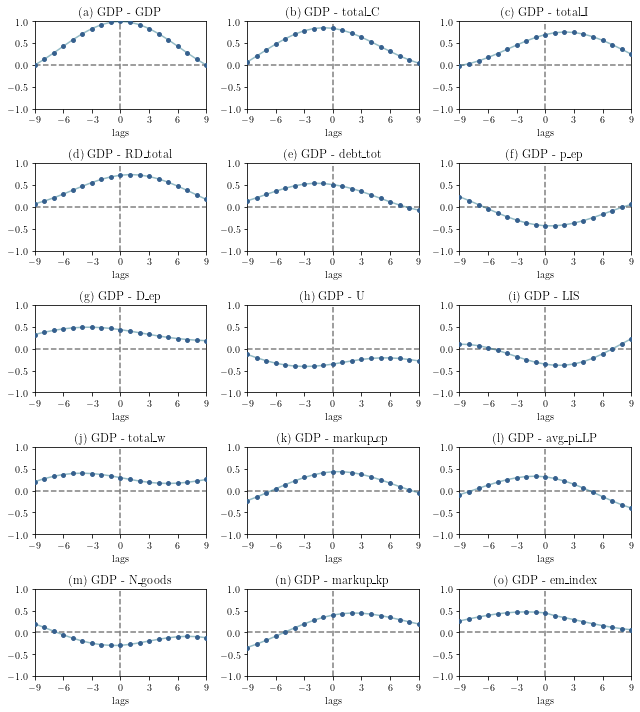

In [16]:
#SF 12, 5
from matplotlib.cm import get_cmap
import statsmodels.api as sm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as smt
import matplotlib.pyplot as plt



def compute_correlations(indicator, apply_bk=False, make_real=False, make_real_y=True, min_lag=-3, max_lag=3, y='GDP'):

    all_corr = []

    for df_part in df_list:

        # Apply filter
        if make_real_y:
            real_GDP =  df_part[y].to_numpy() / df_part.p_ep.to_numpy()
        else:
            real_GDP =  df_part[y].to_numpy()
        gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), bk_low, bk_high, bk_K)

        # Prepare data
        ind_data = df_part[indicator].to_numpy()

        if indicator == 'inventories':
            ind_data = ind_data / (df_part['total_C'].to_numpy() / df_part['p_ep'].to_numpy())
        
        if make_real:
            ind_data = ind_data / df_part.p_ep.to_numpy()

        if apply_bk:
            ind_data = sm.tsa.filters.bkfilter(np.log(ind_data), bk_low, bk_high, bk_K)

        ccf_back = smt.ccf(gdp_filtered[::-1], ind_data[::-1])[1:-min_lag+1][::-1]
        ccf_forw = smt.ccf(gdp_filtered, ind_data)[:max_lag+1]
        ccf = np.concatenate((ccf_back, ccf_forw))

        all_corr.append([ccf])

    avg_corr = np.transpose(np.mean(np.array(all_corr), axis=0))

    return avg_corr

# Modified function to perform the analysis on just one of the time series in the list
def compute_correlations_single_series(df_new, indicator, apply_bk=False, make_real=False, make_real_y=True, min_lag=-3, max_lag=3, y='GDP', series_index=1):
    """
    This function performs cross-correlation analysis on a single time series from the list of dataframes.

    Parameters:
        - df_list (list): List of dataframes containing the data
        - indicator (str): Name of the indicator column
        - apply_bk (bool): Whether to apply Baxter-King filter to the indicator
        - make_real (bool): Whether to adjust the indicator for inflation/price level
        - make_real_y (bool): Whether to adjust the target (usually GDP) for inflation/price level
        - min_lag (int): Minimum lag for cross-correlation
        - max_lag (int): Maximum lag for cross-correlation
        - y (str): Name of the target column, defaults to 'GDP'
        - series_index (int): Index of the time series to analyze from the list. Defaults to the first one (0).

    Returns:
        - ccf (numpy.ndarray): Cross-correlation values
    """
    
    # Fetch the specific dataframe from the list using the index
    df_part = df_new
    
    # Apply filter to the target (usually GDP)
    if make_real_y:
        real_GDP = df_part[y].to_numpy() / df_part['p_ep'].to_numpy()
    else:
        real_GDP = df_part[y].to_numpy()
    gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), bk_low, bk_high, bk_K)
    
    # Prepare the indicator data
    ind_data = df_part[indicator].to_numpy()
    if indicator == 'inventories':
        ind_data = ind_data / (df_part['total_C'].to_numpy() / df_part['p_ep'].to_numpy())
    if make_real:
        ind_data = ind_data / df_part['p_ep'].to_numpy()
    if apply_bk:
        ind_data = sm.tsa.filters.bkfilter(np.log(ind_data), bk_low, bk_high, bk_K)
    
    # Compute cross-correlation
    ccf_back = smt.ccf(gdp_filtered[::-1], ind_data[::-1])[1:-min_lag+1][::-1]
    ccf_forw = smt.ccf(gdp_filtered, ind_data)[:max_lag+1]
    ccf = np.concatenate((ccf_back, ccf_forw))
    
    return ccf

def safe_log(arr):
    """Compute the logarithm where arr > 0, leave other values untouched."""
    result = np.empty_like(arr)
    mask = arr > 0
    result[mask] = np.log(arr[mask])
    result[~mask] = arr[~mask]  # Leave zero or negative values untouched
    return result

def safe_std(arr):
    """Compute the standard deviation where arr is not NaN, leave other values untouched."""
    mask = ~np.isnan(arr)
    if np.any(mask):
        return np.std(arr[mask])
    return np.nan

def compute_correlations_single_series_robust(df, indicator, apply_bk=False, make_real=False, make_real_y=True, min_lag=-3, max_lag=3, y='GDP'):
    if make_real_y:
        real_GDP = df[y].to_numpy() / df['p_ep'].to_numpy()
    else:
        real_GDP = df[y].to_numpy()
        
    gdp_filtered = sm.tsa.filters.bkfilter(safe_log(real_GDP), bk_low, bk_high, bk_K)

    
    ind_data = df[indicator].to_numpy()
    
    if indicator == 'inventories':
        ind_data = ind_data / (df['total_C'].to_numpy() / df['p_ep'].to_numpy())
        
    if make_real:
        ind_data = ind_data / df['p_ep'].to_numpy()
        
    if apply_bk:
        ind_data = sm.tsa.filters.bkfilter(safe_log(ind_data), bk_low, bk_high, bk_K)

    
    # Compute cross-correlation using safe standard deviation calculation
    ccf_back = np.correlate(gdp_filtered[::-1] - np.mean(gdp_filtered), ind_data[::-1] - np.mean(ind_data), 'full') / (safe_std(gdp_filtered) * safe_std(ind_data) * len(gdp_filtered))
    ccf_forw = np.correlate(gdp_filtered - np.mean(gdp_filtered), ind_data - np.mean(ind_data), 'full') / (safe_std(gdp_filtered) * safe_std(ind_data) * len(gdp_filtered))
    
    # Only keep the relevant lags
    ccf_back = ccf_back[len(gdp_filtered)-1:-min_lag][::-1]
    ccf_forw = ccf_forw[len(gdp_filtered)-1:max_lag+1]
    
    ccf = np.concatenate((ccf_back, ccf_forw))
    
    # # Check for zero-size array or NaN values and handle them
    # if ccf.size == 0 or np.isnan(ccf).all():
    #     return np.array([0])  # return an array of zero if ccf is empty or all NaNs
    
    # # Normalize the ccf values to fit within [-1, 1]
    # ccf = ccf / np.max(np.abs(ccf))
    
    return ccf

def compute_correlations_final(df_new, indicator, apply_bk=False, make_real=False, make_real_y=True, min_lag=-3, max_lag=3, y='GDP', series_index=1):
    """
    This function performs cross-correlation analysis on a single time series from the list of dataframes.

    Parameters:
        - df_list (list): List of dataframes containing the data
        - indicator (str): Name of the indicator column
        - apply_bk (bool): Whether to apply Baxter-King filter to the indicator
        - make_real (bool): Whether to adjust the indicator for inflation/price level
        - make_real_y (bool): Whether to adjust the target (usually GDP) for inflation/price level
        - min_lag (int): Minimum lag for cross-correlation
        - max_lag (int): Maximum lag for cross-correlation
        - y (str): Name of the target column, defaults to 'GDP'
        - series_index (int): Index of the time series to analyze from the list. Defaults to the first one (0).

    Returns:
        - ccf (numpy.ndarray): Cross-correlation values
    """
    
    # Fetch the specific dataframe from the list using the index
    df_part = df_new

    #ignore the first 300 time steps
    df_part = df_part.iloc[300:]
    
    # Apply filter to the target (usually GDP)
    if make_real_y:
        real_GDP = df_part[y].to_numpy() / df_part['p_ep'].to_numpy()
    else:
        real_GDP = df_part[y].to_numpy()
    gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP), bk_low, bk_high, bk_K)
    
    # Prepare the indicator data
    ind_data = df_part[indicator].to_numpy()
    if indicator == 'inventories':
        ind_data = ind_data / (df_part['total_C'].to_numpy() / df_part['p_ep'].to_numpy())
    if make_real:
        ind_data = ind_data / df_part['p_ep'].to_numpy()
    if apply_bk:
        ind_data = sm.tsa.filters.bkfilter(np.log(ind_data), bk_low, bk_high, bk_K)
    
    # Compute cross-correlation
    ccf_back = smt.ccf(gdp_filtered[::-1], ind_data[::-1])[1:-min_lag+1][::-1]
    ccf_forw = smt.ccf(gdp_filtered, ind_data)[:max_lag+1]
    ccf = np.concatenate((ccf_back, ccf_forw))
    
    return ccf

'''
# Example of how to call the function
# ccf_result = compute_correlations_single_series(df_list, 'total_C', series_index=0)
# print(ccf_result)

#open csv as df from location '25 Data/2345_model.csv'
# df_new = pd.read_csv('25 Data/2345_model.csv')

# lags = 9
# min_lag = -lags
# max_lag = lags

# indicators = ['GDP', 'total_C', 'total_I', 'RD_total', 'debt_tot', 'p_ep', 'D_ep', 
#               'U', 'LIS', 'total_w',  'markup_cp', 'avg_pi_LP', 'N_goods', 'markup_kp','em_index']
# # indicators = ['GDP', 'total_C', 'I', 'U', 'EnDem', 'Em']
# lags = np.arange(min_lag, max_lag + 1)


# #plt.style.use(['science','ieee'])
# custom_cmap = get_cmap('viridis')
# plt.tight_layout()




# fig, axes = plt.subplots(5, 3, figsize=(9, 10))

# for i, (indicator, ax) in enumerate(zip(indicators, axes.flatten())):

#     fig_nr = chr(i + 97)

#     title = indicator

#     apply_bk = True
#     make_real = True

#     if indicator in ['markups', 'D_ep', 'carbon_emissions', 'LIS', 'total_w', 'p_ep', 'avg_π_LP', 'inventories']:
#         make_real=False
#         if indicator == 'total_w':
#             title = 'nominal wages'
#         elif indicator == 'avg_π_LP':
#             title = '$\\bar{LP}$'
#         elif indicator == 'inventories':
#             title = 'Ivt-Sales'

#     if indicator == 'real wages':
#         indicator = 'wages'
        
#     # if indicator in ['U', 'N_goods', 'em_index']:
#     #     all_r = compute_correlations_single_series(df_list, indicator, min_lag=min_lag, max_lag=max_lag, y='GDP')
#     # else:
#     all_r = compute_correlations_single_series(df_new, indicator, apply_bk=apply_bk, make_real=make_real,
#                                         min_lag=min_lag, max_lag=max_lag)

#     ax.hlines(0, min_lag, max_lag, linestyle='dashed', color='grey')
#     ax.vlines(0, -1., 1, linestyle='dashed', color='grey')

#     print(len(lags), len(all_r))

#     ax.scatter(lags, all_r, color=custom_cmap(0.3), zorder=10, s=15)
#     ax.plot(lags, all_r, alpha=0.5, color=custom_cmap(0.4), zorder=9)

#     ax.set_ylim(-1., 1.)
#     ax.set_xlim(min_lag, max_lag)
#     ax.set_xticks(np.linspace(min_lag, max_lag, 7))
#     ax.set_yticks(np.linspace(-1, 1, 5))
#     ax.set_title(f'({fig_nr}) GDP - {title}')
#     ax.set_xlabel('lags')

# plt.tight_layout()
# # plt.savefig('../../plotting/validation/cross_correlations_short.pdf', bbox_inches='tight')
# plt.show()
'''

df_new = pd.read_csv('../data/1234_model.csv')

epsilon = 1e-9  # Small value for shifting
df_new['U'] += epsilon * (df_new['U'] == 0)
df_new['N_goods'] += epsilon * (df_new['N_goods'] == 0)
df_new['em_index'] += epsilon * (df_new['em_index'] == 0)

lags = 9
min_lag = -lags
max_lag = lags
indicators = ['GDP', 'total_C', 'total_I', 'RD_total', 'debt_tot', 'p_ep', 'D_ep', 
              'U', 'LIS', 'total_w',  'markup_cp', 'avg_pi_LP', 'N_goods', 'markup_kp','em_index']
lags = np.arange(min_lag, max_lag + 1)

custom_cmap = get_cmap('viridis')

fig, axes = plt.subplots(5, 3, figsize=(9, 10))

for i, (indicator, ax) in enumerate(zip(indicators, axes.flatten())):
    fig_nr = chr(i + 97)
    title = indicator
    apply_bk = True
    make_real = True

    if indicator in ['markups', 'D_ep', 'carbon_emissions', 'LIS', 'total_w', 'p_ep', 'avg_π_LP', 'inventories']:
        make_real = False

    all_r = compute_correlations_final(df_new, indicator, apply_bk=apply_bk, make_real=make_real,
                                       min_lag=min_lag, max_lag=max_lag)

    ax.hlines(0, min_lag, max_lag, linestyle='dashed', color='grey')
    ax.vlines(0, -1., 1, linestyle='dashed', color='grey')

    ax.scatter(lags, all_r, color=custom_cmap(0.3), zorder=10, s=15)
    ax.plot(lags, all_r, alpha=0.5, color=custom_cmap(0.4), zorder=9)

    ax.set_ylim(-1., 1.)
    ax.set_xlim(min_lag, max_lag)
    ax.set_xticks(np.linspace(min_lag, max_lag, 7))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_title(f'({fig_nr}) GDP - {title}')
    ax.set_xlabel('lags')

plt.tight_layout()
plt.show()

## Data Preparation SF 11 

* income and wealth Distributions

In [17]:
def powerlaw(x, alpha, beta):
    return beta * x ** (-1 - alpha)

df_I_W = pd.read_csv('../data/final_income_dists.csv')

start_60 = round(20/100 * 2500)
end_60 = round(80/100 * 2500)

I_sorted = np.sort(df_I_W.all_I.to_numpy())
I_share = sum(I_sorted[start_60:end_60]) / sum(I_sorted)
print("I share:", I_share)

W_sorted = np.sort(df_I_W.all_W.to_numpy())
W_share = sum(W_sorted[start_60:end_60]) / sum(W_sorted)
print("W share:", W_share)

I share: 0.5634014493093502
W share: 0.49164997574910196


<Figure size 432x288 with 0 Axes>

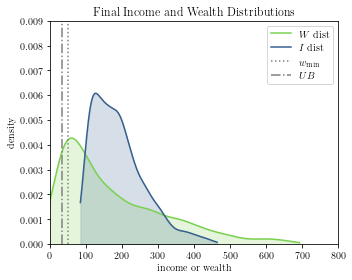

In [18]:

plt.tight_layout()

custom_cmap = get_cmap('viridis')


fig, ax = plt.subplots(figsize=(5, 4))

kde = stats.gaussian_kde(df_I_W.all_W.to_numpy())

W_range = np.linspace(min(df_I_W.all_W), max(df_I_W.all_W), 1000)
prob = kde(W_range)

ax.plot(W_range, prob, label='$W$ dist', color=custom_cmap(0.8))
ax.fill_between(W_range, prob, alpha=0.2, color=custom_cmap(0.8))

kde = stats.gaussian_kde(df_I_W.all_I.to_numpy())

I_range = np.linspace(min(df_I_W.all_I), max(df_I_W.all_I), 1000)
prob = kde(I_range)

ax.plot(I_range, prob, label='$I$ dist', color=custom_cmap(0.3))
ax.fill_between(I_range, prob, alpha=0.2, color=custom_cmap(0.3))

ax.set_xlim(0, 800)
ax.set_ylim(0.0, 0.009)
ax.set_xlabel('income or wealth')
ax.set_ylabel('density')
#title
ax.set_title('Final Income and Wealth Distributions')

ax.axvline(50, c='grey', linestyle='dotted', label='$w_{\min}$')
ax.axvline(35, c='grey', linestyle='dashdot', label='$UB$')
ax.legend()

plt.tight_layout()
#plt.savefig('../../plotting/validation/I_W_dist.pdf', bbox_inches='tight')
plt.show()

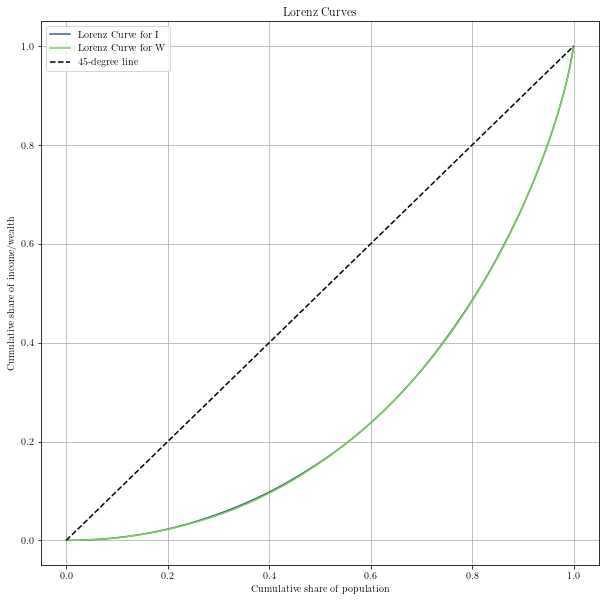

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to compute the Lorenz curve
def lorenz_curve(data):
    n = len(data)
    x = np.arange(1, n+1) / n
    y = np.cumsum(np.sort(data)) / np.sum(data)
    return x, y

custom_cmap = get_cmap('viridis')

# Generate some sample data for illustration
# You should replace these with `I_sorted` and `W_sorted` from your data
I_sorted = np.sort(np.random.exponential(scale=50, size=2500))
W_sorted = np.sort(np.random.exponential(scale=100, size=2500))

# Calculate Lorenz curves
x_I, y_I = lorenz_curve(I_sorted)
x_W, y_W = lorenz_curve(W_sorted)

# Plotting
plt.figure(figsize=(10, 10))

# Plot Lorenz curves
plt.plot(x_I, y_I, label="Lorenz Curve for I", color=custom_cmap(0.3))
plt.plot(x_W, y_W, label="Lorenz Curve for W", color=custom_cmap(0.8))

# Plot 45-degree line
plt.plot([0, 1], [0, 1], 'k--', label="45-degree line")

plt.xlabel("Cumulative share of population")
plt.ylabel("Cumulative share of income/wealth")
plt.title("Lorenz Curves")
plt.legend()
plt.grid(True)

plt.show()

## SF 2 GDP growth distribution

Plot in Paper has been sampled from longer simulation with 1500 periods.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


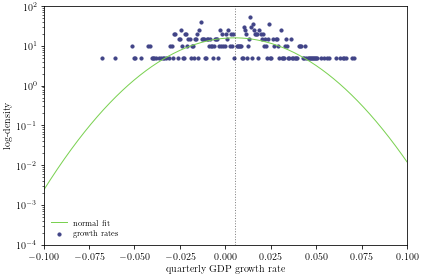

In [21]:
#plot distribution of GDP growth rates
#add df called df from "../data/1234_model.csv"
df = pd.read_csv("../data/1234_model.csv").iloc[300:]

data = df.GDP_growth / 100
mean_GDP_growth = np.mean(data)
x = np.linspace(-0.1, 0.1, 1000)
dens, bins, _ = plt.hist(data, bins=250, density=True, alpha=0.)
mu, sigma = stats.norm.fit(data)
best_fit_line = stats.norm.pdf(x, mu, sigma)
bins1 = bins[:-1]
bins2 = bins[1:]



bins = np.mean([bins1, bins2], axis=0)


plt.style.use(['science','ieee'])
plt.tight_layout()



plt.plot(x, best_fit_line, color=custom_cmap(0.8), label='normal fit')
plt.scatter(bins, dens, s=10, c=custom_cmap(0.2), label='growth rates')
plt.legend(loc='lower left')
plt.xlabel('quarterly GDP growth rate')
plt.ylabel('log-density')
plt.xlim(-0.1, 0.1)
plt.ylim(10e-5, 100)
plt.axvline(mean_GDP_growth, linestyle='dotted', alpha=0.5, c='black')

plt.yscale('log')
plt.tight_layout()
#plt.savefig('../../plotting/validation/gr_dist.pdf', bbox_inches='tight')
plt.show()

## SF3 The duration of recessions is exponentially distributed.

(Partial) reproduction of Dosi (2017) fig 3

In [24]:
# Count recession periods
durations = []
recession = False

for g in df.GDP_growth:

    if g < 0:
        if recession:
            duration += 1
        else:
            recession = True
            duration = 1
        
    elif g > 0 and recession:
        recession = False
        durations += [duration]

durations = np.array(durations)



loc, scale = stats.expon.fit(durations)

counts = {}
for d in durations:
    if d not in counts:
        counts[d] = 1
    else:
        counts[d] += 1

totcount = sum(counts.values())

for c in counts:
    counts[c] /= totcount



<Figure size 1980x1500 with 0 Axes>

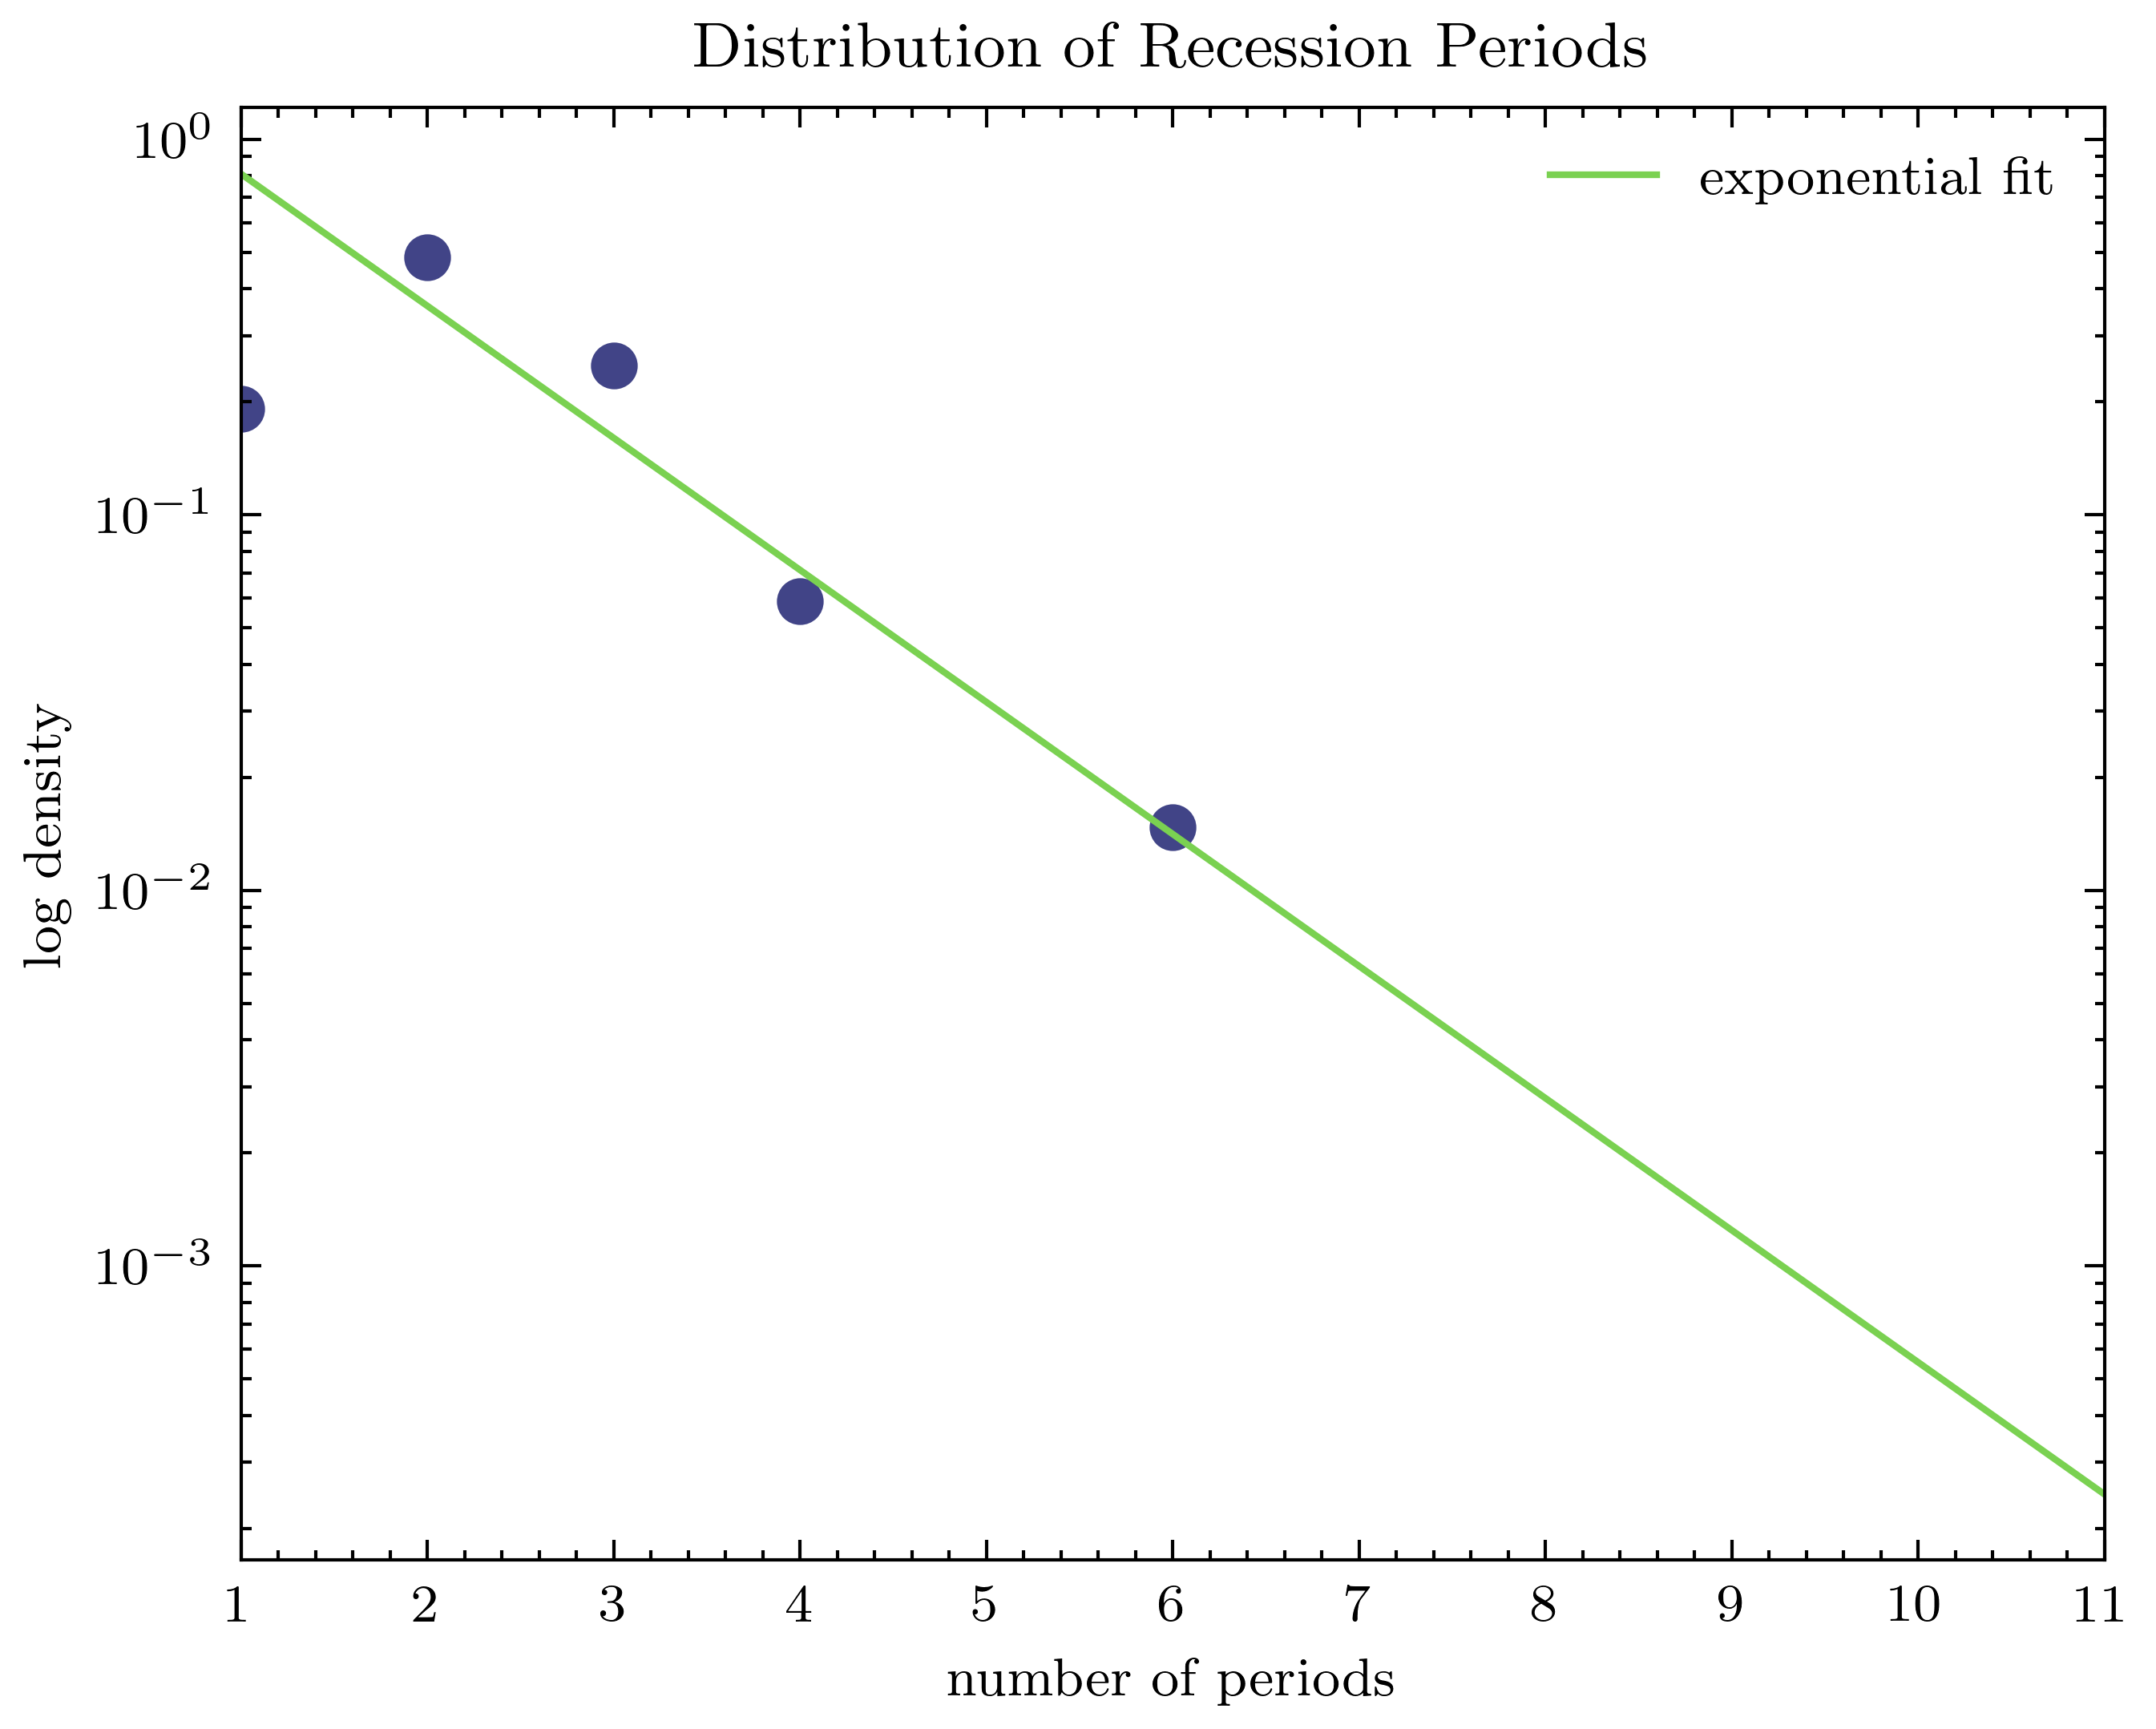

In [25]:

plt.tight_layout()


plt.figure(figsize=(5,4))

x = np.linspace(1, 11, 100)

plt.plot(x, stats.expon.pdf(x, loc, scale), label='exponential fit', c=custom_cmap(0.8))
plt.scatter(counts.keys(), counts.values(), color=custom_cmap(0.2))
# plt.scatter(np.linspace(1, max(bins), len(dens)), dens, label='simulated data', c='red', s=30, zorder=2)
plt.xlim(1, 11)
plt.xticks(range(1, 12))
plt.yscale('log')
plt.title('Distribution of Recession Periods')
plt.xlabel('number of periods')
plt.ylabel('log density')
plt.legend()

#plt.savefig('../../plotting/validation/rec_fit.pdf', bbox_inches='tight')
plt.show()

## SF related to Firms

### SF 7,8
Firms investment lumpiness.



In [39]:
import pandas as pd
import numpy as np
import scipy.stats as stats

def load_and_process_data(file_path):
    df = pd.read_csv(file_path).sort_values(by='timestamp')
    yearly_size = np.array([df['size'][i:i+12].sum() for i in range(0, len(df), 12)])
    return yearly_size

def normalize_and_sort(data):
    min_value = data.min()
    normalized_data = np.sort(data / min_value)[::-1]
    return normalized_data


def statistical_tests(data):
    log_data = np.log(data)
    jb_val, jb_p = stats.jarque_bera(log_data)
    sw_stat, sw_p = stats.shapiro(log_data)
    ad_stat, _, _ = stats.anderson(log_data, dist='norm')
    return pd.DataFrame({
        'Jarque-Bera': [jb_val, round(jb_p, 2)],
        'Shapiro-Wilkes': [sw_stat, round(sw_p, 2)],
        'Anderson-Darling': [ad_stat, 0.0]
    }, index=['test stat', 'p-val']).round(2)

# Load data
df_new1 = load_and_process_data('../data/1234_kp_firm.csv')
#normalize and sort data
df_new1 = normalize_and_sort(df_new1)


# Statistical tests
df_firmtable = statistical_tests(df_new1)
print(df_firmtable.head())
print(df_firmtable.to_latex())



           Jarque-Bera  Shapiro-Wilkes  Anderson-Darling
test stat       444.93            0.97              5.06
p-val             0.00            0.00              0.00
\begin{tabular}{lrrr}
\toprule
{} &  Jarque-Bera &  Shapiro-Wilkes &  Anderson-Darling \\
\midrule
test stat &       444.93 &            0.97 &              5.06 \\
p-val     &         0.00 &            0.00 &              0.00 \\
\bottomrule
\end{tabular}



/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_19344/841711448.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yearly_size = np.array([df['size'][i:i+12].sum() for i in range(0, len(df), 12)])
/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_19344/841711448.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_firmtable.to_latex())


<Figure size 1980x1500 with 0 Axes>

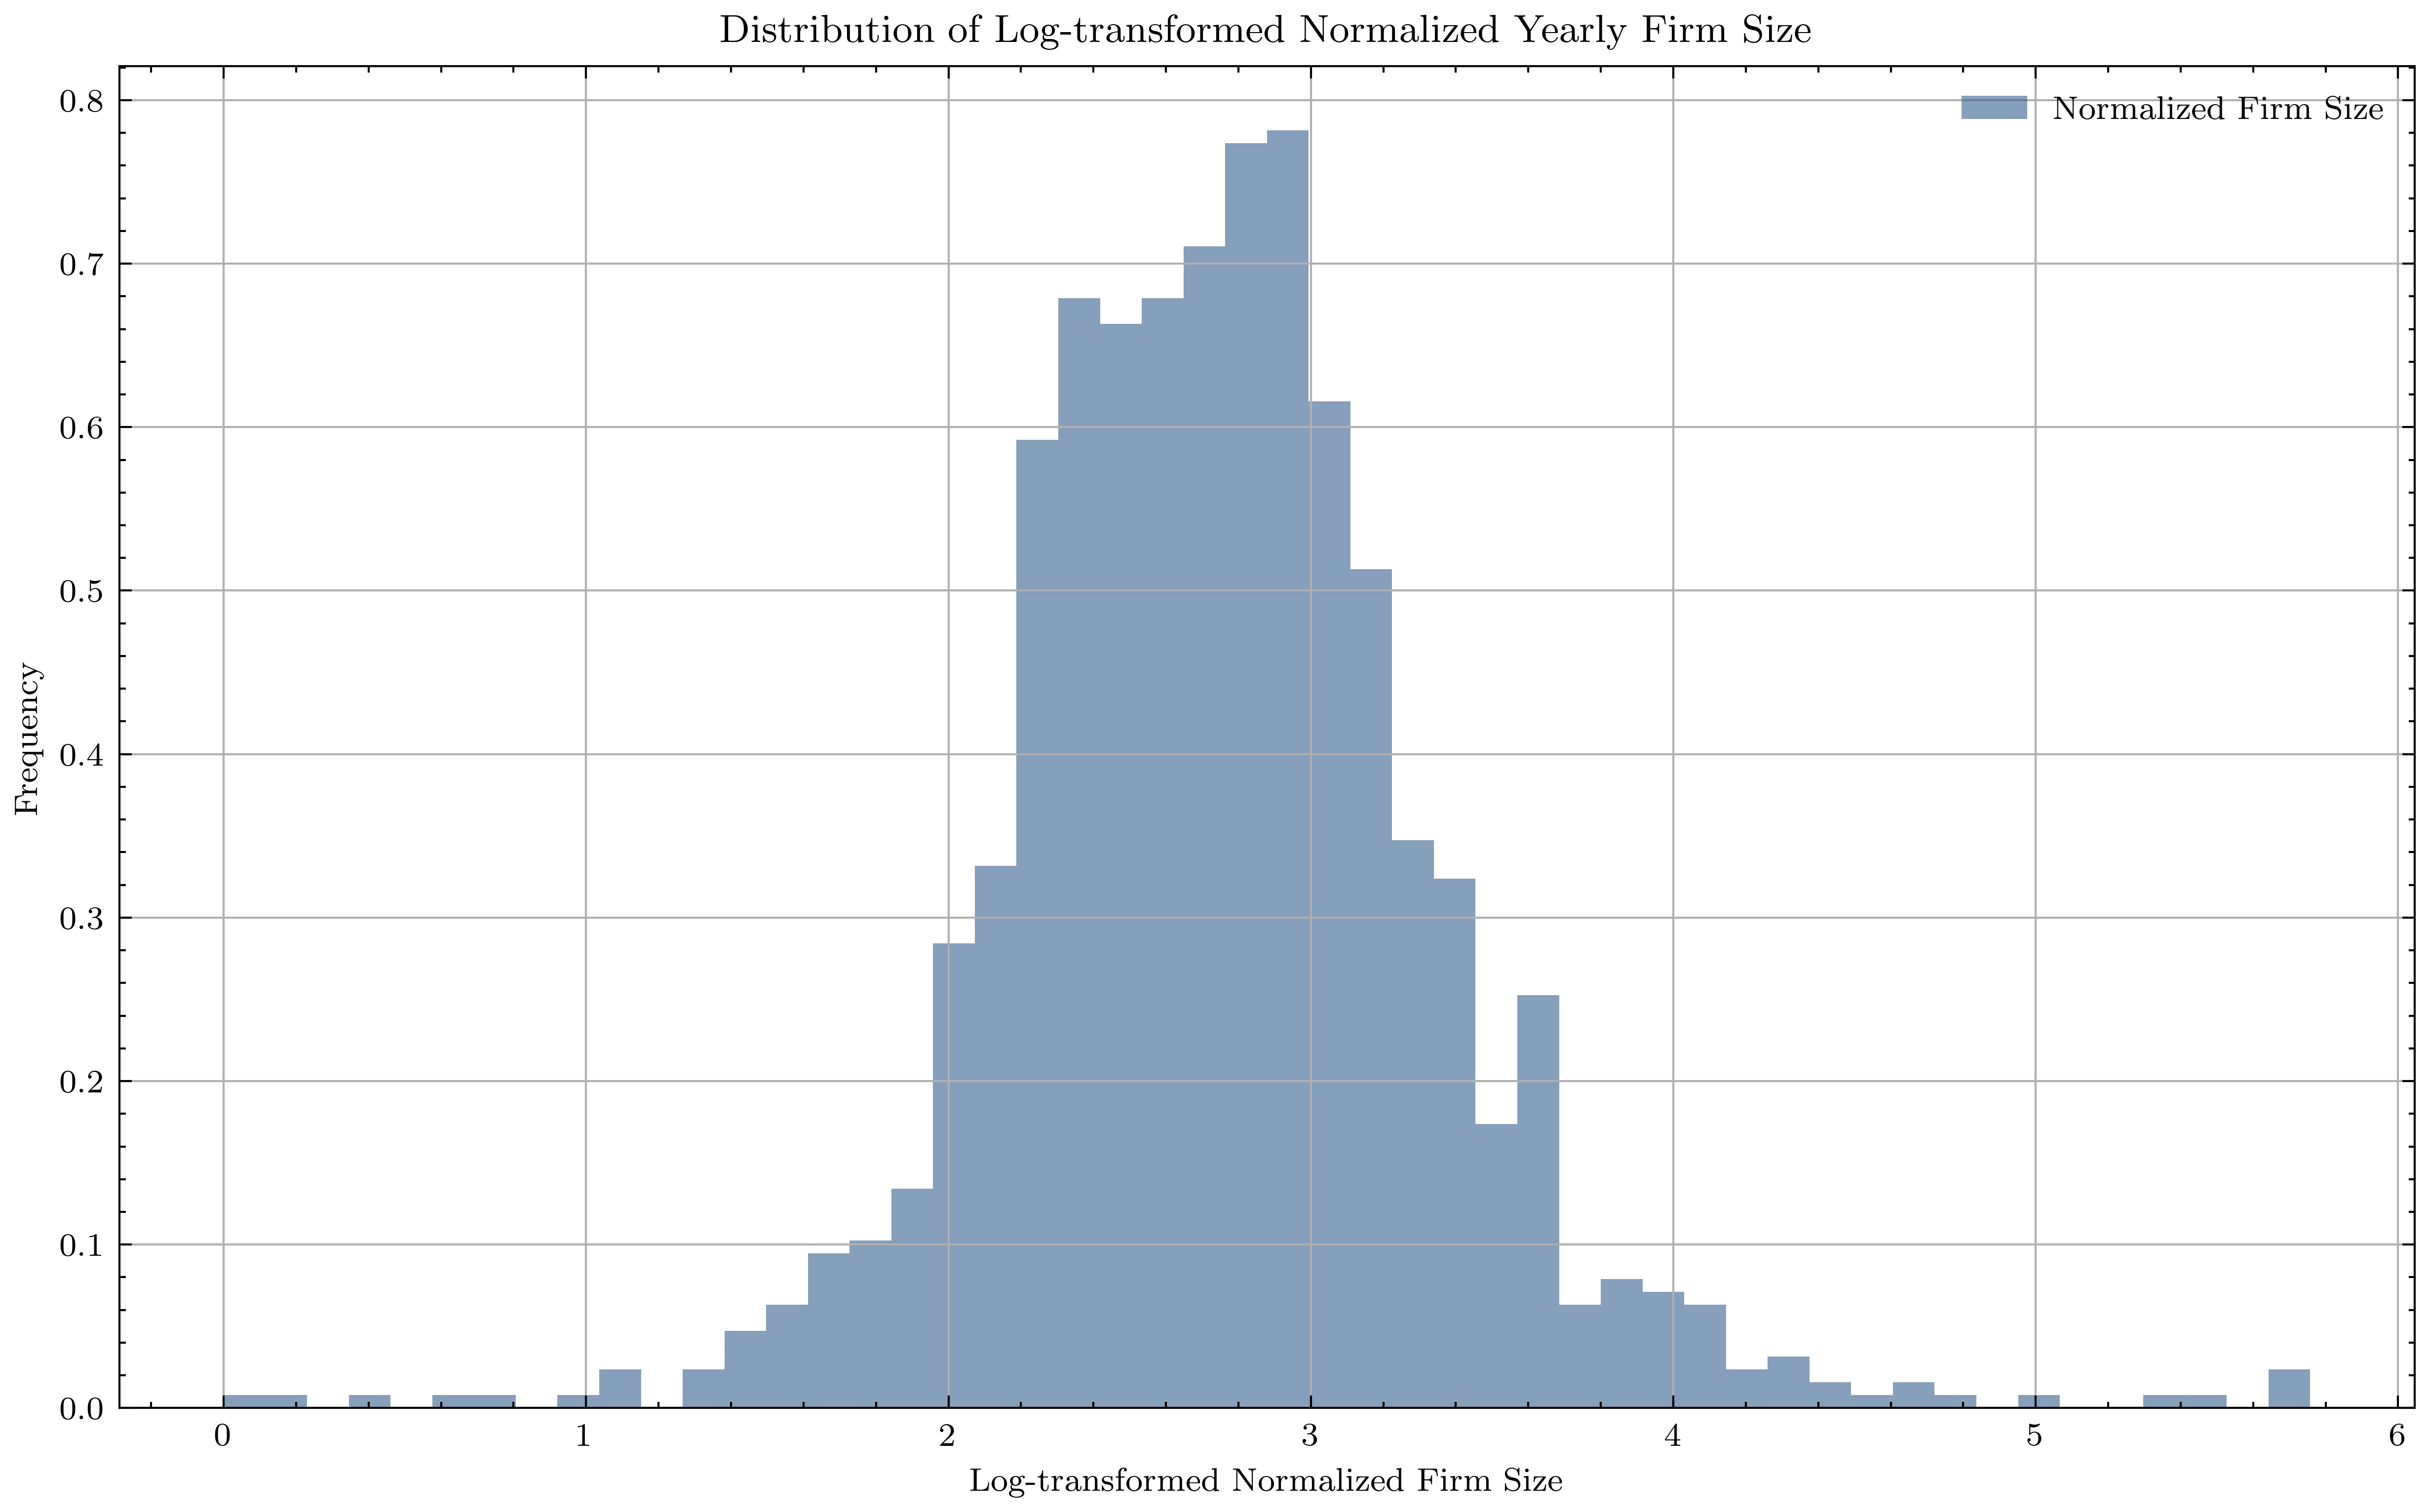

In [40]:
import matplotlib.pyplot as plt

# Log-transform the normalized employee data for plotting
log_size_year_norm = np.log(df_new1)

plt.tight_layout()
#use viridis package for colors
custom_cmap = get_cmap('viridis')

# Generate the plot
plt.figure(figsize=(10, 6))
plt.hist(log_size_year_norm, bins=50, density=True, alpha=0.6, color=custom_cmap(0.3), label='Normalized Firm Size')
plt.title('Distribution of Log-transformed Normalized Yearly Firm Size')
plt.xlabel('Log-transformed Normalized Firm Size')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


## SF 9,10

The plot from the paper is averaged over mutliple runs.


In [50]:
import os


# Specify the folder where the CSV files are located
folder_path = "../data"  # Replace with your actual folder path

# List all files in the specified folder
all_files = os.listdir(folder_path)

# Filter out files whose names contain 'kp_firm' and end with '.csv'
kp_firm_files = [f for f in all_files if 'kp_firm' in f and f.endswith('.csv')]

# Read these files into a list of DataFrames
dfs_filtered = [pd.read_csv(os.path.join(folder_path, f)) for f in kp_firm_files]

# Concatenate the filtered DataFrames along rows
df_concatenated1 = pd.concat(dfs_filtered, ignore_index=True)

#save aggregated data to csv
#df_concatenated1.to_csv('kp_firm_aggregated.csv', index=False)



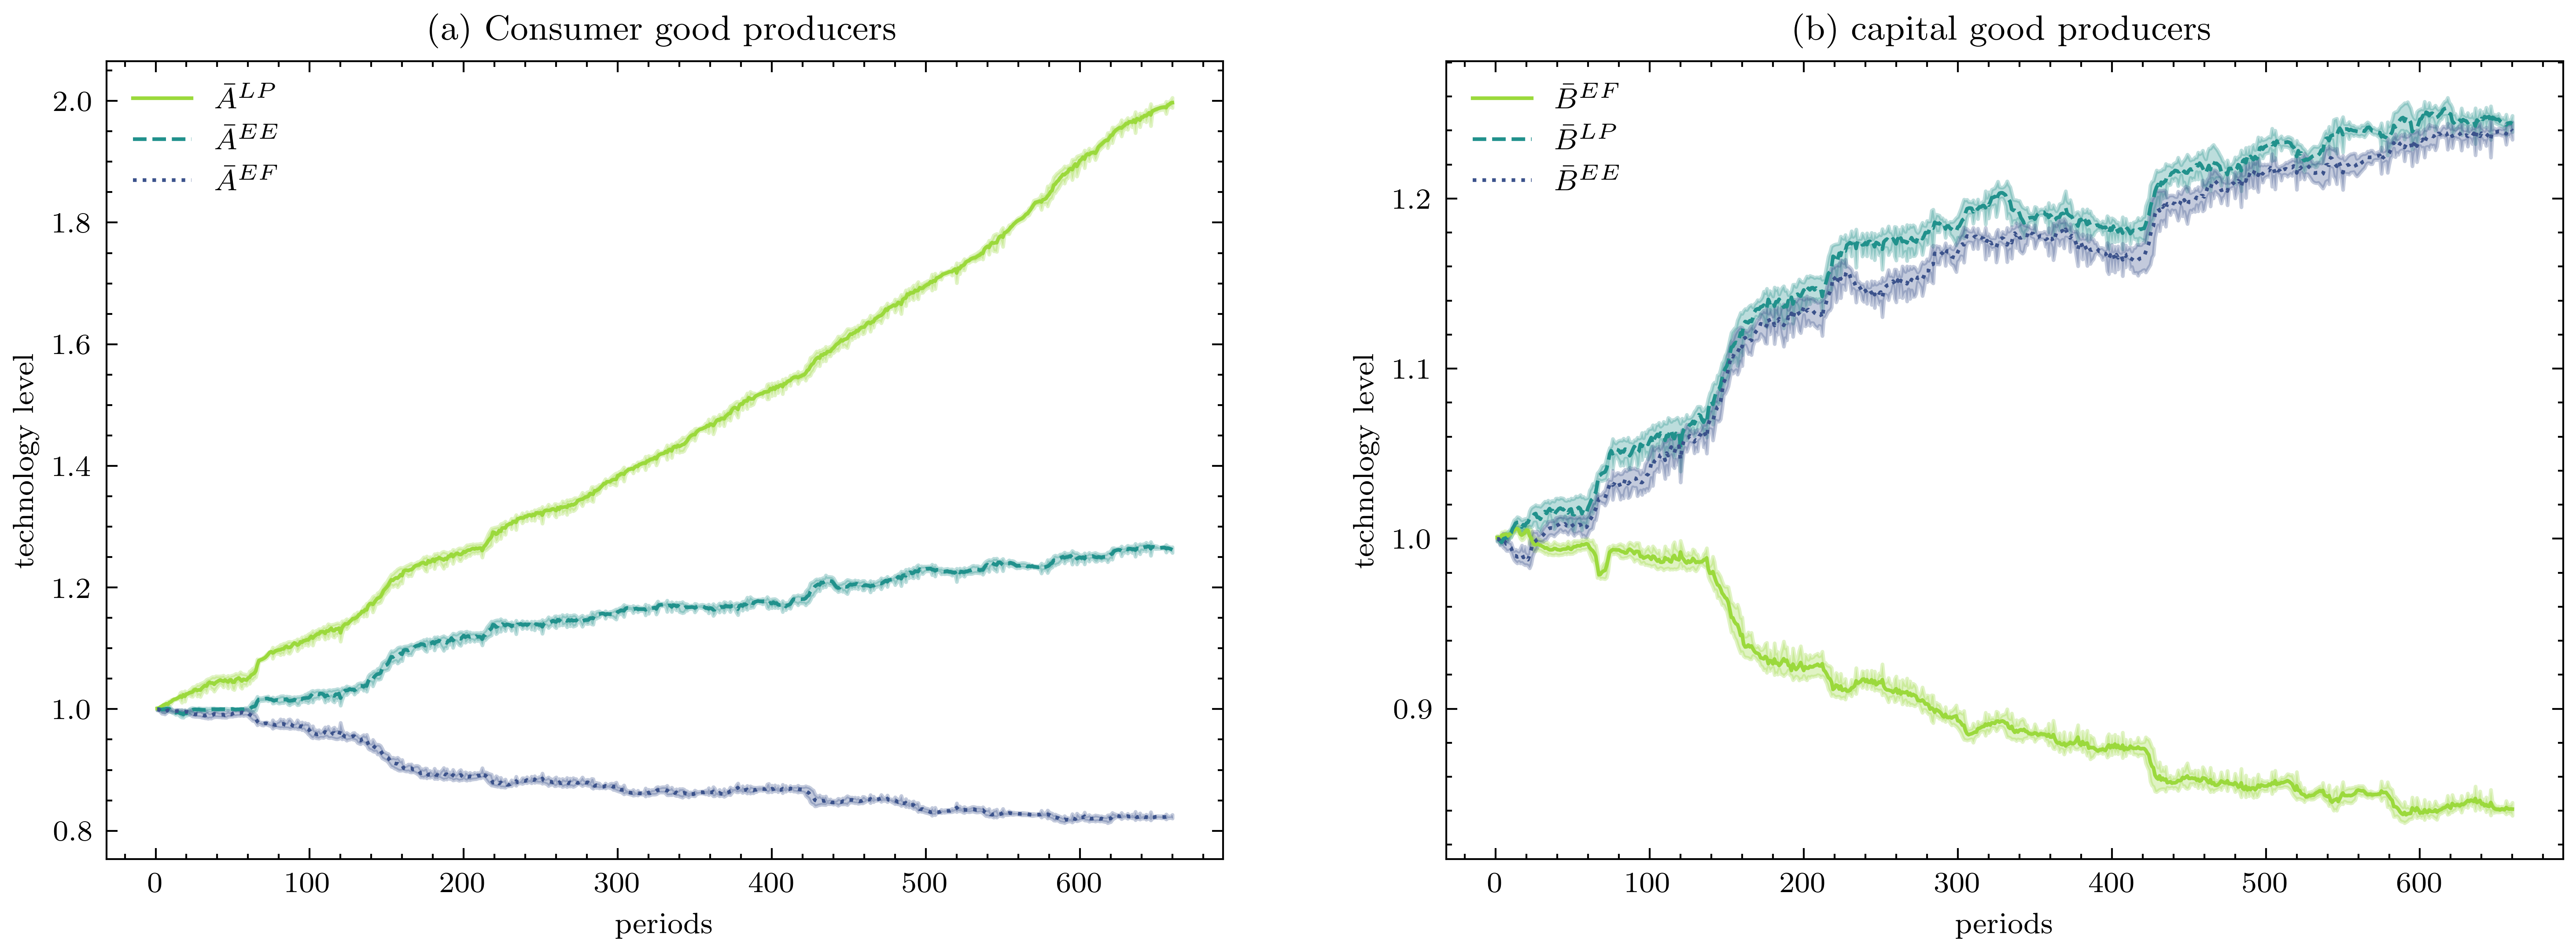

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap

#plt.style.use(['science','ieee'])
#plt.tight_layout()
custom_cmap = get_cmap('viridis')

def raw_stats(colstart, dataframe):
    cols = [col for col in dataframe.columns if col.startswith(colstart)]
    group_by_timestamp = dataframe.groupby('timestamp')[cols]
    ts_mean = group_by_timestamp.mean().mean(axis=1)
    ts_std = group_by_timestamp.std().mean(axis=1)
    return ts_mean, ts_std

# Create subplots
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 4))

# Plot for A_ variables (Consumer good producers on the left)
for colstart, color, label in zip(['A_LP', 'A_EE', 'A_EF'], [0.85, 0.5, 0.25], ['$\\bar{A}^{LP}$', '$\\bar{A}^{EE}$', '$\\bar{A}^{EF}$']):
    ts_mean, ts_std = raw_stats(colstart, df_concatenated1)
    ax1.plot(ts_mean, color=custom_cmap(color), label=label)
    ax1.fill_between(ts_mean.index, ts_mean - ts_std, ts_mean + ts_std, alpha=0.3, color=custom_cmap(color))

ax1.legend(loc='upper left')
ax1.set_xlabel('periods')
ax1.set_ylabel('technology level')
ax1.set_title('(a) Consumer good producers')

# Plot for B_ variables (Capital good producers on the right)
for colstart, color, label in zip(['B_EF', 'B_LP', 'B_EE'], [0.85, 0.5, 0.25], ['$\\bar{B}^{EF}$', '$\\bar{B}^{LP}$', '$\\bar{B}^{EE}$']):
    ts_mean, ts_std = raw_stats(colstart, df_concatenated1)
    ax2.plot(ts_mean, color=custom_cmap(color), label=label)
    ax2.fill_between(ts_mean.index, ts_mean - ts_std, ts_mean + ts_std, alpha=0.3, color=custom_cmap(color))

ax2.legend(loc='upper left')
ax2.set_xlabel('periods')
ax2.set_ylabel('technology level')
ax2.set_title('(b) capital good producers')

#plt.tight_layout()
plt.show()


In [52]:
import os


# Specify the folder where the CSV files are located
folder_path = "../data"  # Replace with your actual folder path

# List all files in the specified folder
all_files = os.listdir(folder_path)

# Filter out files whose names contain 'kp_firm' and end with '.csv'
cp_firm_files = [f for f in all_files if 'cp_firm' in f and f.endswith('.csv')]

# Read these files into a list of DataFrames
dfs_filtered = [pd.read_csv(os.path.join(folder_path, f)) for f in cp_firm_files]

# Concatenate the filtered DataFrames along rows
df_concatenated = pd.concat(dfs_filtered, ignore_index=True)

#save aggregated data to csv
#df_concatenated.to_csv('cp_firm_aggregated2.csv', index=False)



/var/folders/n5/636hh_6s0pl03rdtjj6fd0vw0000gn/T/ipykernel_19344/111446471.py:24: RuntimeWarning: invalid value encountered in divide
  I_ratio = I_month / K_month


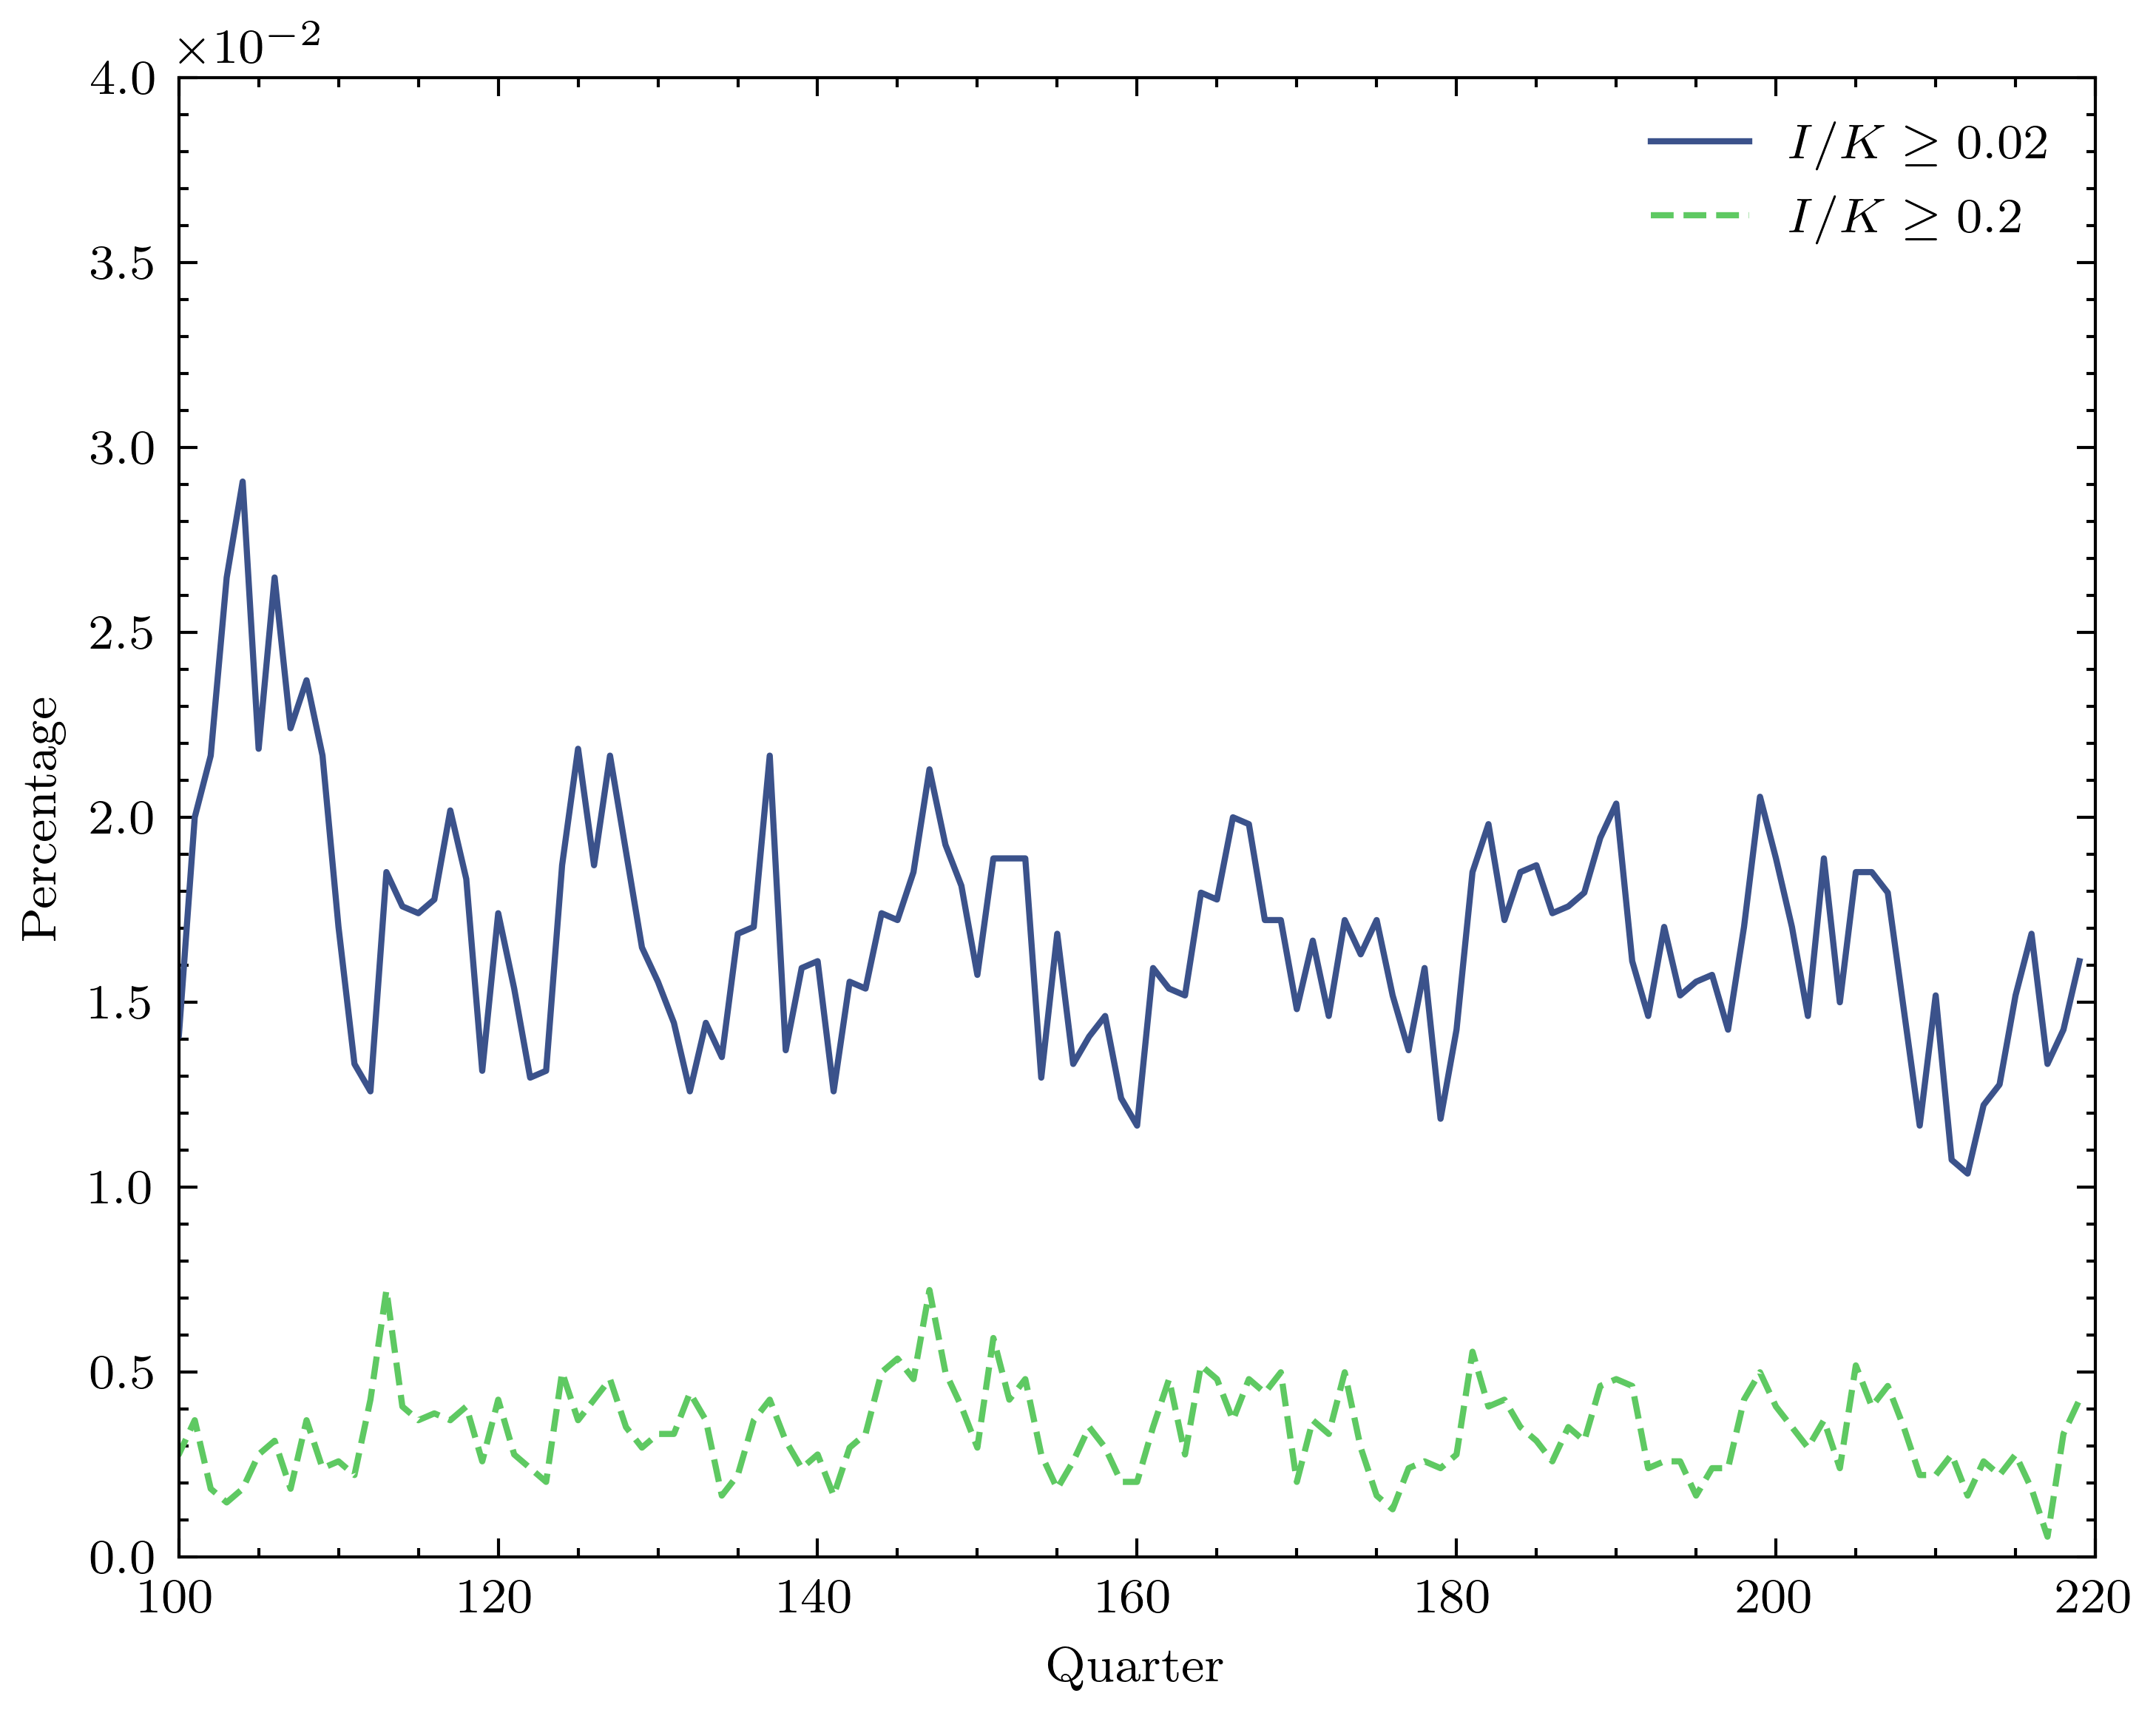

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap
#import FormatStrFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter

# Load and sort data by timestamp
data_path_aggregated = '../data/1234_cp_firm.csv'
df_aggregated = pd.read_csv(data_path_aggregated).sort_values(by=['timestamp'])

# Extract columns related to TCI and K
I_cols = [col for col in df_aggregated.columns if col.startswith("TCI")]
K_cols = [col for col in df_aggregated.columns if col.startswith("K")]

# Check for required columns
if not I_cols or not K_cols:
    raise ValueError("Required columns missing. Check if 'TCI' and 'K' columns exist.")

# Calculate monthly I/K ratios
I_month = df_aggregated[I_cols].to_numpy()
K_month = df_aggregated[K_cols].to_numpy()
I_ratio = I_month / K_month

# Identify conditions for I_ratio
I_ratio_02 = np.where(I_ratio >= 0.2, 1, 0)
I_ratio_002 = np.where(I_ratio >= 0.02, 1, 0)

# Aggregate data quarterly
step_size = 3 * 200  # 3 timesteps multiplied by entries per timestep
I_ratio_quarterly_02 = np.array([np.sum(I_ratio_02[i:i+step_size, :], axis=0) for i in np.arange(0, I_ratio_02.shape[0], step=step_size)]) / (1800 * 3)
I_ratio_quarterly_002 = np.array([np.sum(I_ratio_002[i:i+step_size, :], axis=0) for i in np.arange(0, I_ratio_002.shape[0], step=step_size)]) / (1800 * 3)

# Plotting setup
custom_cmap = get_cmap('viridis')
fig, ax1 = plt.subplots(figsize=(5, 4))

# Create the plot
ax1.plot(np.sum(I_ratio_quarterly_002, axis=1), label='$I/K \geq 0.02$', color=custom_cmap(0.25))
ax1.plot(np.sum(I_ratio_quarterly_02, axis=1), label='$I/K \geq 0.2$', color=custom_cmap(0.75))

# Customize plot
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Percentage')
ax1.legend(loc='upper right')
#limit x axist from 200 to end
ax1.set_xlim(100, len(I_ratio_quarterly_002))
#put ylim to 0 to 0.04
ax1.set_ylim(0, 0.04)
# Set y-axis to scientific notation
formatter = ScalarFormatter()
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))
ax1.yaxis.set_major_formatter(formatter)
# Show the plot
plt.tight_layout()
plt.show()


